# Exploratory Data Analysis on COVID-19 in Malta

## Overview

COVID-19 has had a global impact in all aspects of our daily lives, be it in the way we work, communicate and entertain ourselves as well as in our daily habits with regards to health. In Malta, the first official cases of COVID-19 were recorded in March 2020. One of the first actions taken was the suspension of certain travel routes and eventually, a full closure of the national airport. 

This notebook will explore the timeline of COVID-19 in Malta in terms of the daily tests, vaccination and recorded cases. The monthly aggregated data will also be explored in-line with the monthly arrivals at the Malta International Airport (MIA) in Luqa. Thus, this notebook will attempt to address the hypothesis that airline travel has a direct impact on the daily amount of registered COVID-19 cases.

Some key dates in the timeline of COVID-19 in Malta are denoted below:
- 7th March 2020: The first COVID-19 cases were detected in Malta
- 11th March 2020: The start of the travel ban and travel quarantine.
- 8th April 2020: The first COVID-19 death in Malta was reported.
- August 2020: Travel to Malta was opened again.
- 19th October 2020: The compulsory use of face masks was enforced.
- November 2020: Start of rollout of COVID-19 vaccine.
- May 2021: Health authorities declared herd immunity.
- November 2021: Start of the first booster vaccine rollout.
- 25th July 2022: No testing required for unvaccinated travellers
- 17th October 2022: Rollout of Omicron booster along with the influenza vaccine.

## Data Preparation

For this analysis, two distinct data sources will be used. The first dataset contains COVID-19 data based in Malta and is maintained by the COVID-19 Public Health Response Team (Ministry for Health). The dataset is publicly available at https://github.com/COVID19-Malta/COVID19-Data and is split into numerous subsets. We will be considering the following for this analysis:

1. Aggregate Data - Active Cases, Recoveries and Deaths
2. Vaccination Data - Including dose number and boosters
3. COVID Test Data - PCR and Rapid Antigen Tests

The second dataset is maintained by Eurostat (https://ec.europa.eu/eurostat/databrowser/view/avia_par_mt/default/table?lang=en) and contains data about the airline travel between MIA and its partner airports. The dataset contains monthly, quarterly and annual aggregations as well as various measures based on passengers, seats or flights.

Before performing Exploratory Data Analysis (EDA) on each dataset, a level of preprocessing is required. This involves importing, analysis and cleaning of the data as well as the merging of different datasets. To do so, we will be using Python as well as a number of libraries.

In [1]:
# We import the required packages

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### COVID-19 Datasets

The first COVID-19 dataset is the aggregate dataset. To start off, we import the dataset and preview the first and last rows of the dataset as well as the columns' respective data types.

In [2]:
df_covid_agg = pd.read_csv('./data/covid/COVID-19 Malta - Aggregate Data Set.csv')
df_covid_agg.head() # the first few records
df_covid_agg.tail() # the last records

,Date,New Cases,Total Cases,Recovered,Deaths,Active Cases
1021,22/12/2022,19,116196,114725,812,263
1022,23/12/2022,16,116212,114737,813,266
1023,24/12/2022,19,116231,114746,813,276
1024,25/12/2022,16,116247,114763,813,275
1025,26/12/2022,6,116253,114773,813,271


In [3]:
df_covid_agg.dtypes # the datatypes for each column

Date            object
New Cases        int64
Total Cases      int64
Recovered        int64
Deaths           int64
Active Cases     int64
dtype: object

In [4]:
df_covid_agg.isnull().values.any() # checking for null values

False

The aggregate dataset contains a daily summary of the active cases, recoveries and deaths. The dataset starts from the 06/03/2020 and the data of retrieval i.e. 26/12/2022. The number of days between the first and last date is 1026 days. Therefore, the dataset is expected to have 1026 unique dates or rows.

In [5]:
df_covid_agg.shape # checking the dataframe dimensions (row x column)

(1026, 6)

While there are 1026 rows, a check must also be done for duplicate dates. This can be done by using the 'duplicated' method on the 'Date' column.

In [6]:
df_covid_agg['dup_date'] = df_covid_agg.duplicated(subset=['Date'])
agg_data_dupes = df_covid_agg.loc[df_covid_agg['dup_date'] == True]
agg_data_dupes 

,Date,New Cases,Total Cases,Recovered,Deaths,Active Cases,dup_date
1000,01/11/2022,21,115839,114444,809,190,True


The row with index 1000 seems to be a duplicate. We can investigate further by checking a few rows before and after the duplicate entry.

In [7]:
df_covid_agg.iloc[997:1004] # getting row indices from 997 to 1004

,Date,New Cases,Total Cases,Recovered,Deaths,Active Cases,dup_date
997,28/11/2022,6,115775,114399,809,171,False
998,29/11/2022,15,115790,114415,809,170,False
999,30/11/2022,28,115818,114433,809,180,False
1000,01/11/2022,21,115839,114444,809,190,True
1001,02/12/2022,12,115851,114468,809,178,False
1002,03/12/2022,6,115857,114479,809,173,False
1003,04/12/2022,13,115870,114487,809,178,False


It seems as if the date is wrongly set as 01/11/2022 instead if 01/12/2022. This can be amended manually after converting to the datetime format.

The final step is to convert the 'Date' column into the datetime data type. This will be helpful when plotting or grouping data.

In [8]:
df_covid_agg = df_covid_agg.drop('dup_date', axis=1) # drop the extra column
df_covid_agg.columns = ['date','new_cases','total_cases','recovered','deaths','active_cases'] # set the column names
df_covid_agg['date'] = pd.to_datetime(df_covid_agg['date'],format="%d/%m/%Y") # convert to datetime from 'dd/mm/yyyy' format
df_covid_agg.iat[1000,0] = pd.to_datetime('01/12/2022',format="%d/%m/%Y")
df_covid_agg.iloc[997:1004]
# df_covid_agg.head()


,date,new_cases,total_cases,recovered,deaths,active_cases
997,2022-11-28,6,115775,114399,809,171
998,2022-11-29,15,115790,114415,809,170
999,2022-11-30,28,115818,114433,809,180
1000,2022-12-01,21,115839,114444,809,190
1001,2022-12-02,12,115851,114468,809,178
1002,2022-12-03,6,115857,114479,809,173
1003,2022-12-04,13,115870,114487,809,178


The second COVID-19 dataset is the vaccination dataset. After importing the data, we can preview the dataset and the column datatypes.

In [9]:
df_covid_vacc = pd.read_csv('./data/covid/COVID-19 Malta - Vaccination Data.csv')
df_covid_vacc.head()

,Date of Vaccination,Total Vaccination Doses,Primary Vaccination,Received one dose,Total Booster doses,Total 2nd Booster doses,Omicron booster doses,Total Omicron booster doses
0,17/01/2021,11705,NaN,NaN,NaN,NaN,NaN,NaN
1,18/01/2021,13002,NaN,NaN,NaN,NaN,NaN,NaN
2,19/01/2021,14276,NaN,NaN,NaN,NaN,NaN,NaN
3,20/01/2021,15316,NaN,NaN,NaN,NaN,NaN,NaN
4,21/01/2021,16531,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_covid_vacc.dtypes

Date of Vaccination             object
Total Vaccination Doses         object
Primary Vaccination            float64
Received one dose               object
Total Booster doses             object
Total 2nd Booster doses         object
Omicron booster doses          float64
Total Omicron booster doses    float64
dtype: object

In [11]:
df_covid_vacc.isnull().values.any()

True

The vaccination dataset contains daily counts of the total vaccinations as well as the vaccinations by subset (primary dose, booster dose, Omicron booster etc.). At first glance, the dataset seems to have mixed datatypes for values which are definitely integers. There are also NaN values which can be replaced by 0s. Similar to the aggregate dataset, a check is performed for duplicate dates.

In [12]:
df_covid_vacc.shape # 708 rows/days are expected between the first (17/01/2021) and last (26/12/2022) records of this dataset

(708, 8)

In [13]:
df_covid_vacc['dup_date'] = df_covid_vacc.duplicated(subset=['Date of Vaccination'])
vacc_data_dupes = df_covid_vacc.loc[df_covid_vacc['dup_date'] == True]
vacc_data_dupes

,Date of Vaccination,Total Vaccination Doses,Primary Vaccination,Received one dose,Total Booster doses,Total 2nd Booster doses,Omicron booster doses,Total Omicron booster doses,dup_date
683,01/11/2022,1372894,471220.0,478417,361240,73771,238.0,22627.0,True


The same date as the aggregate dataset seems to have been misentered. This record will be manually amended as in the previous case.

The column names will be changed for simplicity and to be in line between all the datasets. The 'date' column will be converted to a datetime format.

In [14]:
df_covid_vacc = df_covid_vacc.drop('dup_date', axis=1) # drop the extra column
df_covid_vacc.columns = ['date','total_doses','primary_vacc','one_dose','total_booster_1','total_booster_2','daily_booster_omicron','total_booster_omicron']
df_covid_vacc['date'] = pd.to_datetime(df_covid_vacc['date'],format="%d/%m/%Y") # convert to datetime from 'dd/mm/yyyy' format
df_covid_vacc.iat[683,0] = pd.to_datetime('01/12/2022',format="%d/%m/%Y")

In [15]:
df_covid_vacc.iloc[680:686]

,date,total_doses,primary_vacc,one_dose,total_booster_1,total_booster_2,daily_booster_omicron,total_booster_omicron
680,2022-11-28,1371855,471208.0,478404,361213,73351,228.0,22060.0
681,2022-11-29,1372092,471208.0,478404,361219,73464,118.0,22178.0
682,2022-11-30,1372447,471219.0,478417,361231,73597,163.0,22364.0
683,2022-12-01,1372894,471220.0,478417,361240,73771,238.0,22627.0
684,2022-12-02,1373248,471233.0,478434,361254,73899,164.0,22809.0
685,2022-12-03,1373294,471239.0,478442,361262,73916,7.0,22816.0


In [16]:
df_covid_vacc.dtypes

date                     datetime64[ns]
total_doses                      object
primary_vacc                    float64
one_dose                         object
total_booster_1                  object
total_booster_2                  object
daily_booster_omicron           float64
total_booster_omicron           float64
dtype: object

Since the columns represent counts, all the columns can be converted to an integer data type, defaulting to NaN. Any NaN values can be changed to 0s.

In [17]:
int_cols = [x for x in df_covid_vacc.columns if x != 'date'] # all the non-date columns
df_covid_vacc[int_cols] = df_covid_vacc[int_cols].apply(pd.to_numeric, errors='coerce', downcast='integer') # convert to integer, defaulting to NaN if an error occurs
df_covid_vacc.fillna(0,inplace=True, downcast='infer') # replace all NaN values with 0s
df_covid_vacc.dtypes

date                     datetime64[ns]
total_doses                       int64
primary_vacc                      int64
one_dose                          int64
total_booster_1                   int64
total_booster_2                   int64
daily_booster_omicron             int64
total_booster_omicron             int64
dtype: object

The third and last COVID-19 dataset is the testing dataset. As per the previous datasets, we can load it and preview the data.

In [18]:
df_covid_tests = pd.read_csv('./data/covid/COVID-19 Malta - COVID Tests.csv')
df_covid_tests.head(10)

,Publication date,NAA tests in previous day,Total NAA tests,Rapid antigen tests in previous day,Total rapid antigen tests,NAA and rapid antigen tests in previous day,Total NAA and rapid antigen tests
0,20/07/2020,583,113820,NaN,NaN,583,113820
1,21/07/2020,959,114779,NaN,NaN,959,114779
2,22/07/2020,1016,115795,NaN,NaN,1016,115795
3,23/07/2020,1114,116909,NaN,NaN,1114,116909
4,24/07/2020,931,117840,NaN,NaN,931,117840
5,25/07/2020,1085,118925,NaN,NaN,1085,118925
6,26/07/2020,1220,120145,NaN,NaN,1220,120145
7,27/07/2020,850,120995,NaN,NaN,850,120995
8,28/07/2020,1353,122348,NaN,NaN,1353,122348
9,29/07/2020,1615,123963,NaN,NaN,1615,123963


In [19]:
df_covid_tests.dtypes

Publication date                                object
NAA tests in previous day                        int64
Total NAA tests                                  int64
Rapid antigen tests in previous day            float64
Total rapid antigen tests                      float64
NAA and rapid antigen tests in previous day      int64
Total NAA and rapid antigen tests                int64
dtype: object

The testing dataset contains daily data on tests performed in the previous day, grouped by the test type (NAA/PCR or Rapid Antigen) as well as the cumulative sum of tests to date. From the datatypes, the same preprocessing done to the vaccination dataset is required to convert the 'date' column to datetime and the rest of the columns to integers. 

Another note is that the individual previous day tests (NAA, rapid antigen) do not always add up to the value in the combined NAA and rapid antigen tests for the previous day. 

As a duplicate date entry for 01/12/2022 was detected in the previous datasets, the same check will be done for the testing dataset.

In [20]:
df_covid_tests.shape # 890 rows/days are expected between the first (20/07/2020) and last (26/12/2022) records of this dataset

(890, 7)

In [21]:
df_covid_tests['dup_date'] = df_covid_tests.duplicated(subset=['Publication date'])
test_data_dupes = df_covid_tests.loc[df_covid_tests['dup_date'] == True]
test_data_dupes

,Publication date,NAA tests in previous day,Total NAA tests,Rapid antigen tests in previous day,Total rapid antigen tests,NAA and rapid antigen tests in previous day,Total NAA and rapid antigen tests,dup_date


In this case, there were no duplicates and thus the date can be transformed to datetime without prior amendments.

In [22]:
df_covid_tests = df_covid_tests.drop('dup_date', axis=1) # drop the extra column
df_covid_tests.columns = ['date','daily_pcr','total_pcr','daily_rapid','total_rapid','total_daily_tests','total_tests']
df_covid_tests['date'] = pd.to_datetime(df_covid_tests['date'],format="%d/%m/%Y") # convert to datetime from 'dd/mm/yyyy' format

Once again, the rest of the columns are counts and can be converted to integers.

In [23]:
int_cols = [x for x in df_covid_tests.columns if x != 'date'] # all the non-date columns
df_covid_tests[int_cols] = df_covid_tests[int_cols].apply(pd.to_numeric, errors='coerce', downcast='integer') # convert to integer, defaulting to NaN if an error occurs
df_covid_tests.fillna(0,inplace=True, downcast='infer') # replace all NaN values with 0s
df_covid_tests.dtypes

date                 datetime64[ns]
daily_pcr                     int16
total_pcr                     int32
daily_rapid                   int64
total_rapid                   int64
total_daily_tests             int16
total_tests                   int32
dtype: object

In [24]:
df_covid_tests.tail()

,date,daily_pcr,total_pcr,daily_rapid,total_rapid,total_daily_tests,total_tests
885,2022-12-22,250,1550990,126,546240,406,2097230
886,2022-12-23,177,1551167,56,546296,233,2097463
887,2022-12-24,148,1551319,78,546374,230,2097693
888,2022-12-25,150,1551471,78,546452,230,2097923
889,2022-12-26,134,1551605,18,546470,152,2098075


### Flights Dataset
Apart from the COVID-19 datasets, we will also be exploring the daily flights arriving at the MIA up til June 2022. The dataset contains several units of measure and we must filter the dataset such that we only retain the information which is useful to us. The metadata for this dataset is available on Eurostat's website.

In [25]:
df_flights = pd.read_csv('./data/flights/estat_avia_par_mt_en.csv')
df_flights.head(10)

,DATAFLOW,LAST UPDATE,freq,unit,tra_meas,airp_pr,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AE_OMDB,2019,937,NaN
1,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LO99,2005,614,NaN
2,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LO99,2006,546,NaN
3,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LO99,2009,548,NaN
4,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LO99,2010,492,NaN
5,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LOWW,2001,520,NaN
6,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LOWW,2002,505,NaN
7,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LOWW,2003,601,NaN
8,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LOWW,2004,606,NaN
9,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LOWW,2007,521,NaN


In [26]:
df_flights.dtypes

DATAFLOW        object
LAST UPDATE     object
freq            object
unit            object
tra_meas        object
airp_pr         object
TIME_PERIOD     object
OBS_VALUE        int64
OBS_FLAG       float64
dtype: object

A a brief summary of the columns from the metadata can be found below:

- DATAFLOW: The name of the dataset
- LAST UPDATE: The date of the last update
- freq: the time frequency; A (annual), Q (quarterly) or M (monthly)
- unit: the unit of measurement; PAS (passengers), SEAT (seats and berths), FLIGHT (flights)
- tra_meas: traffic and transport measures; splits metrics by carried passengers, boarded passengers, arrivals and departures
- airp-pr: the airport pair showing the route data
- TIME_PERIOD: the time, with the format depending on the time frequency
- OBS_VALUE: the observed counts
- OBS_FLAG: true or false flag (unused in this dataset)

Since our COVID datasets are daily in frequency, it makes sense to consider the highest frequency available for this dataset which is the monthly frequency. Furthermore, the most important metric for our analysis are arriving passengers as we don't care about empty seats or departing passengers. Thus, we will filter our dataset on the above criteria:

In [27]:
df_flights_monthly = df_flights.query("freq == 'M' and unit == 'PAS' and tra_meas == 'PAS_CRD_ARR'") # filter by monthly frequency, passengers as the unit of measure and filter by arrivals
df_flights_monthly = df_flights_monthly[df_flights_monthly.TIME_PERIOD.str.startswith('202')] # check from 2020 onwards to be inline with the COVID-19 dates
df_flights_monthly

,DATAFLOW,LAST UPDATE,freq,unit,tra_meas,airp_pr,TIME_PERIOD,OBS_VALUE,OBS_FLAG
69053,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_AE_OMDB,2022-01,1779,NaN
69054,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_AE_OMDB,2022-02,1775,NaN
69055,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_AE_OMDB,2022-03,2528,NaN
69056,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_AE_OMDB,2022-04,2612,NaN
69057,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_AE_OMDB,2022-05,2380,NaN
...,...,...,...,...,...,...,...,...,...
77494,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_UK_EGSS,2022-02,1630,NaN
77495,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_UK_EGSS,2022-03,2800,NaN
77496,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_UK_EGSS,2022-04,5369,NaN
77497,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_UK_EGSS,2022-05,6374,NaN


We can drop the unused columns and rename the rest of the columns accordingly.

In [28]:
df_flights_monthly.drop(labels=['DATAFLOW','LAST UPDATE','freq','unit','tra_meas','OBS_FLAG'],axis=1,inplace=True)
df_flights_monthly

,airp_pr,TIME_PERIOD,OBS_VALUE
69053,MT_LMML_AE_OMDB,2022-01,1779
69054,MT_LMML_AE_OMDB,2022-02,1775
69055,MT_LMML_AE_OMDB,2022-03,2528
69056,MT_LMML_AE_OMDB,2022-04,2612
69057,MT_LMML_AE_OMDB,2022-05,2380
...,...,...,...
77494,MT_LMML_UK_EGSS,2022-02,1630
77495,MT_LMML_UK_EGSS,2022-03,2800
77496,MT_LMML_UK_EGSS,2022-04,5369
77497,MT_LMML_UK_EGSS,2022-05,6374


In [29]:
df_flights_monthly.columns = ['route','date','total_passengers']
df_flights_monthly['date'] = pd.to_datetime(df_flights_monthly['date'],format="%Y-%m") # convert to datetime from 'YYYY-MM' format
df_flights_monthly.head()

,route,date,total_passengers
69053,MT_LMML_AE_OMDB,2022-01-01,1779
69054,MT_LMML_AE_OMDB,2022-02-01,1775
69055,MT_LMML_AE_OMDB,2022-03-01,2528
69056,MT_LMML_AE_OMDB,2022-04-01,2612
69057,MT_LMML_AE_OMDB,2022-05-01,2380


This leaves us with the monthly sum of passengers per route. A useful metric would be to group the total passengers per month, irrespective of the route.

In [30]:
df_monthly_passengers = df_flights_monthly.groupby('date').sum(numeric_only = True) # get the monthly sum of inbound passengers
df_monthly_passengers.head(12)

,total_passengers
date,
2020-01-01,112478
2020-02-01,120242
2020-03-01,41445
2020-04-01,629
2020-05-01,351
2020-06-01,778
2020-07-01,52268
2020-08-01,73473
2020-09-01,39323


## Exploratory Data Analysis

Given that our datasets are all based on time (in different frequencies), they can be viewed as time-series. Thus, we can perform univariate analysis and multivariate analysis on each seperate time-series as well as multivariate analysis on the merged datasets. 

Before starting our analysis, we define some helper functions which simplify the process of plotting and adding annotations. This also allows us to maintain the same style throughout.

### Helper Functions

In [35]:
# a helper function to plot a single y-variable against an x-variable (where required)
def plot_helper(graph_type: str, df: pd.DataFrame, x_key: str, y_key: str=''):
    sns.set_style("whitegrid")
    x_label = x_key.replace('_',' ').title() 
    y_label = y_key.replace('_',' ').title() 
    fig,ax = plt.subplots(figsize=(10,6))
    if graph_type == "line":
        graph = sns.lineplot(data=df,x=x_key,y=y_key,ax=ax)
    elif graph_type == "regression":
        graph = sns.regplot(data=df,x=x_key, y=y_key, ax=ax, line_kws={"color": "orange"})
    graph.axes.set_title(f'{y_label} vs {x_label}',fontsize=14)
    graph.set_xlabel(x_label,fontsize=10)
    graph.set_ylabel(y_label,fontsize=10)

In [36]:
# a helper function to plot multiple y-variables on the same scale against an x-variable 
def multi_plot_helper(graph_type: str, df: pd.DataFrame, x_key: str, y_keys: list =[''],y_label: str=''):
    sns.set_style("whitegrid")
    x_label = x_key.replace('_',' ').title() 
    fig,ax = plt.subplots(figsize=(10,6))
    if graph_type == "line":
        for y_key in y_keys:
            graph = sns.lineplot(data=df,x=x_key,y=y_key,ax=ax, label=y_key.replace('_',' ').title())
    elif graph_type == "hist":
        graph = sns.histplot(data=df,x=x_key)
    graph.axes.set_title(f'{y_label} vs {x_label}',fontsize=14)
    plt.legend()
    graph.set_xlabel(x_label,fontsize=10)
    graph.set_ylabel(y_label,fontsize=10)

In [37]:
# a helper function to plot 2 y-variables with different scales against an x-variable
def dual_axis_plot_helper(df: pd.DataFrame, x_key: str, y_key_1: str, y_key_2: str):
    sns.set_style("whitegrid")
    x_label = x_key.replace('_',' ').title() 
    y_label_1 = y_key_1.replace('_',' ').title() 
    y_label_2 = y_key_2.replace('_',' ').title() 
    fig,ax1 = plt.subplots(figsize=(10,6))
    graph1 = sns.lineplot(data=df,x=x_key,y=y_key_1,ax=ax1, label=y_label_1, color='blue')
    graph1.set_xlabel(x_label,fontsize=10)
    graph1.set_ylabel(y_label_1,fontsize=10)
    ax2=ax1.twinx()
    graph2 = sns.lineplot(data=df,x=x_key,y=y_key_2,ax=ax2, label=y_label_2, color='orange')
    graph2.set_ylabel(y_label_2,fontsize=10)
    graph2.axes.set_title(f'{y_label_1} and {y_label_2} vs {x_label}',fontsize=14)
    ax1.legend_.remove()
    ax2.legend_.remove()
    fig.legend()

In [38]:
# a helper function to plot vertical lines in the graph, can be used to mark significant dates where applicable
def add_plot_line(date: str, label: str, color: str,  x_offset: int,  y_offset: float = 0.9, date_format: str = "%d/%m/%Y"):
    axes = plt.gca()
    dt_date = pd.to_datetime(date,format=date_format)
    plt.axvline(dt_date,0,1,color=color)
    plt.text(dt_date + pd.DateOffset(days=x_offset),plt.axis()[3]*y_offset,label,rotation=0,color=color, bbox=dict(facecolor='white', alpha=0.9))

### Univariate Analysis

Given that our data is a time-series, not all statistical analysis makes sense, especially when considering data with cumulative totals. For example, for the aggregated cases dataset:

In [39]:
df_covid_agg.describe()

,new_cases,total_cases,recovered,deaths,active_cases
count,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,113.409357,46227.762183,44018.139376,406.580897,1601.859649
std,176.474206,41196.286026,40296.635559,282.651774,2372.370059
min,0.000000,1.000000,0.000000,0.000000,1.000000
25%,15.000000,8290.250000,6082.750000,101.500000,222.500000
50%,51.000000,34335.000000,31736.000000,423.000000,652.000000
75%,135.750000,87764.250000,78218.000000,670.500000,2080.500000
max,1403.000000,116253.000000,114773.000000,813.000000,15065.000000


The _total_cases_,_recovered_ and _deaths_ columns are cumulative totals. Looking at the average in this case does not yield useful information. However, looking at the _active_cases_ column and the _new_cases_ column, the data shows that there is a high standard deviation indicating extreme peaks at certain points in time. 

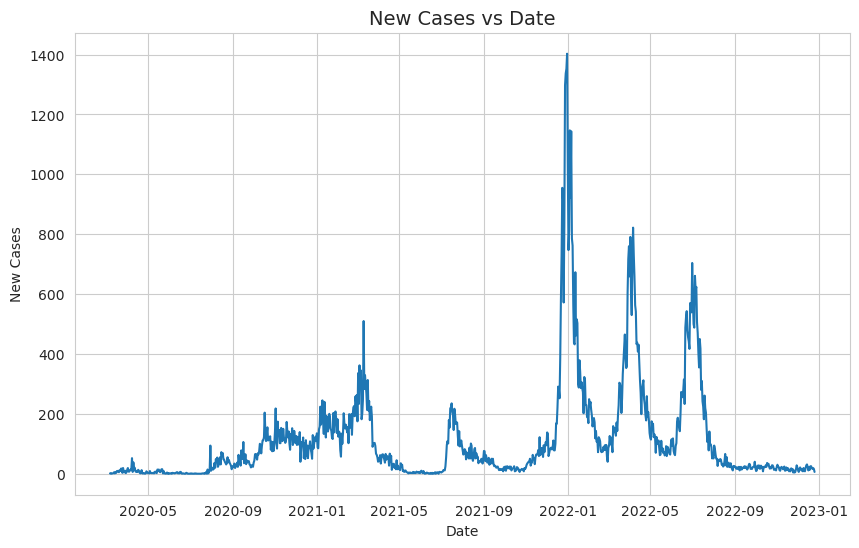

In [40]:
plot_helper('line',df_covid_agg, 'date' , 'new_cases')

From the plot, it seems that peak in in the new recorded cases was between the end of 2021 and the start of 2022. Since the variance at the peak is much higher compared to the other smaller peaks, the lineplot loses some detail. If we look at each year individually, we can get a more detailed picture. Furthermore, adding a weekly rolling average can smoothen the plot.

In [41]:
df_covid_agg['new_cases_weekly_avg'] = df_covid_agg[['new_cases']].rolling(7).mean().shift(-3) # a rolling average to have a smoother curve
df_covid_agg_2020 = df_covid_agg.where(df_covid_agg['date']<pd.to_datetime('01/01/2021',format='%d/%m/%Y'))
df_covid_agg_2021 = df_covid_agg.where(df_covid_agg['date']<pd.to_datetime('01/01/2022',format='%d/%m/%Y')).where(df_covid_agg['date']>=pd.to_datetime('01/01/2021',format='%d/%m/%Y'))
df_covid_agg_2022 = df_covid_agg.where(df_covid_agg['date']>=pd.to_datetime('01/01/2022',format='%d/%m/%Y'))

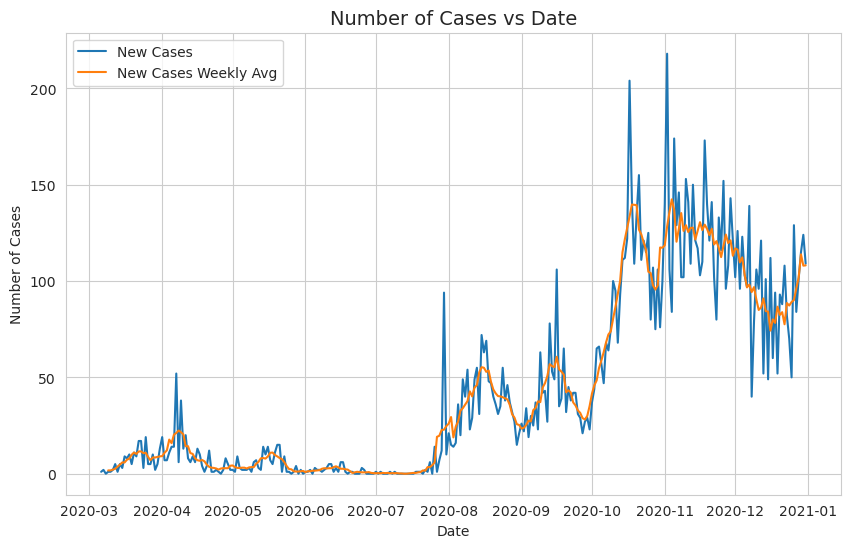

In [42]:
multi_plot_helper('line',df_covid_agg_2020,'date',['new_cases','new_cases_weekly_avg'],'Number of Cases')


As expected, the weekly average curve is much smoother and more legible. Let us take a closer look at the new cases each year.

In [43]:
df_covid_agg_2020.describe()

,new_cases,total_cases,recovered,deaths,active_cases,new_cases_weekly_avg
count,301.000000,301.000000,301.000000,301.000000,301.000000,298.000000
mean,42.787375,3056.734219,2367.568106,38.495017,650.704319,43.195590
std,48.590136,3719.800641,3013.354040,56.558856,739.355644,45.861674
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,584.000000,465.000000,6.000000,64.000000,3.321429
50%,20.000000,874.000000,666.000000,9.000000,332.000000,25.000000
75%,78.000000,4486.000000,3184.000000,45.000000,1257.000000,84.357143
max,218.000000,12774.000000,11121.000000,219.000000,2172.000000,142.428571


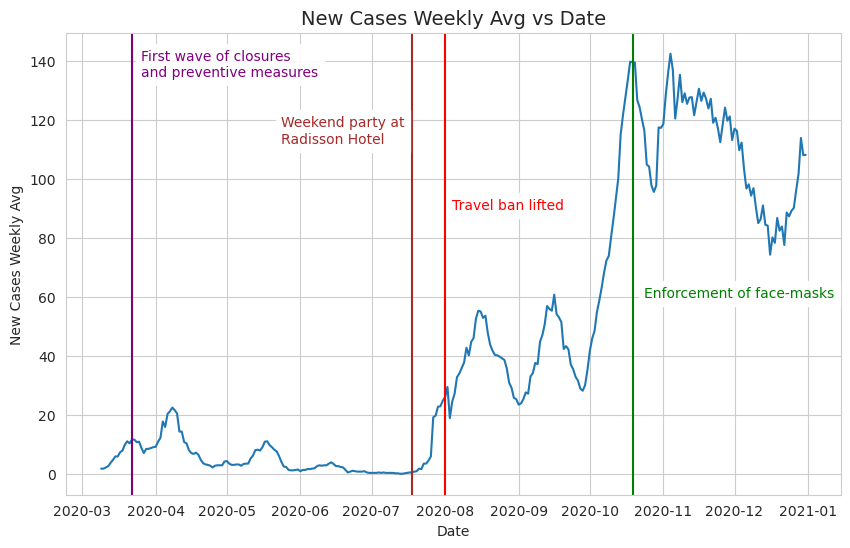

In [44]:
plot_helper('line',df_covid_agg_2020,'date','new_cases_weekly_avg')
add_plot_line('22/03/2020','First wave of closures\nand preventive measures','purple',4, 0.9)
add_plot_line('18/07/2020','Weekend party at\nRadisson Hotel','brown',-55, 0.75)
add_plot_line('01/08/2020','Travel ban lifted','red',3, 0.6)
add_plot_line('19/10/2020','Enforcement of face-masks','green',5, 0.4)

Looking at the above plot for 2020, the number of new cases were varying upwards and downwards relatively steadily between March and mid-July. Following this period, a rapid spike formed from mid-July onwards which coincides with 2 major events:
- The so-called 'COVID Party' which took place at the Radisson Hotel in St Julians.
- The lifting of the travel on a number of countries.

The upward trend continued towards the end of the year, with another large spike in the beginning of October. This coincides with the beginning of the scholastic year which was believed to be a cause of the rapid spike. Towards the end of the year, the number of new cases decreased slightly. This could be partly due to the compulsory use of face masks as well as the beginning of the distribution of the first COVID-19 vaccine. In 2020, the highest number of new cases peaked at 218. 

In [45]:
df_covid_agg_2021.describe()

,new_cases,total_cases,recovered,deaths,active_cases,new_cases_weekly_avg
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,108.756164,31370.652055,29538.383562,402.882192,1254.419178,107.647750
std,178.771028,7626.571093,7724.419506,68.939692,1410.654428,163.692624
min,0.000000,12909.000000,11178.000000,219.000000,23.000000,1.000000
25%,17.000000,29127.000000,28045.000000,395.000000,280.000000,18.428571
50%,56.000000,30633.000000,30161.000000,420.000000,691.000000,55.571429
75%,141.000000,37163.000000,35998.000000,458.000000,2230.000000,152.857143
max,1403.000000,52470.000000,40156.000000,477.000000,11441.000000,1142.857143


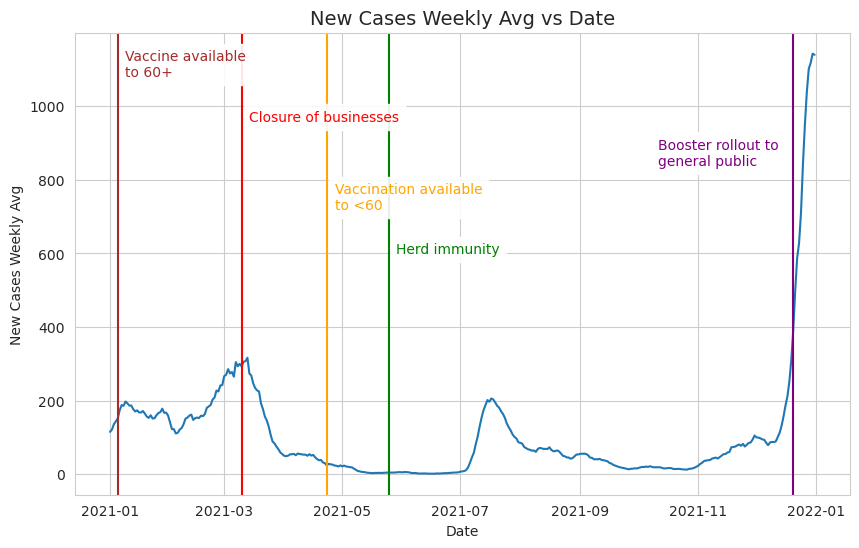

In [46]:
plot_helper('line',df_covid_agg_2021, 'date' , 'new_cases_weekly_avg')
add_plot_line('05/01/2021','Vaccine available\nto 60+','brown',4,0.9)
add_plot_line('10/03/2021','Closure of businesses','red',4,0.8)
add_plot_line('23/04/2021','Vaccination available\nto <60','orange',4,0.6)
add_plot_line('25/05/2021','Herd immunity','green',4,0.5)
add_plot_line('20/12/2021','Booster rollout to\ngeneral public','purple',-70,0.7)

2021 started with a small peak which last until mid-March. A wave of restrictions including the closure of non-essential businesses and a maximum group size of 4 were followed by a rapid decrease in cases through to the summer months. During this time, the vaccine was gradually rolled out to different age groups of the population. In May 2021, the Health Authorities declared that the country had reached herd immunity which coincides with the average cases close to 0. Following a spike in the beginning of July, the number of new daily cases remained relatively low until the end of the year. In fact, the median number of new cases was 56 which is almost half of the yearly average. As the Omicron variant reached Malta and the booster vaccine was introduced, a rapid surge in new cases caused the daily number of cases to exceed 1400 by the end of the year. 

In [47]:
df_covid_agg_2022.describe()

,new_cases,total_cases,recovered,deaths,active_cases,new_cases_weekly_avg
count,360.00000,360.000000,360.000000,360.000000,360.000000,357.000000
mean,177.17500,97386.997222,93523.508333,718.091667,2749.397222,179.685474
std,215.08182,19063.759462,21044.936889,98.442013,3375.345226,212.783189
min,4.00000,53500.000000,40405.000000,477.000000,90.000000,9.857143
25%,23.00000,80033.250000,73111.750000,638.000000,276.000000,21.285714
50%,89.00000,102862.500000,95631.500000,740.500000,1421.500000,89.000000
75%,252.00000,114610.750000,113171.000000,804.500000,3953.750000,252.285714
max,1147.00000,116253.000000,114773.000000,813.000000,15065.000000,1118.428571


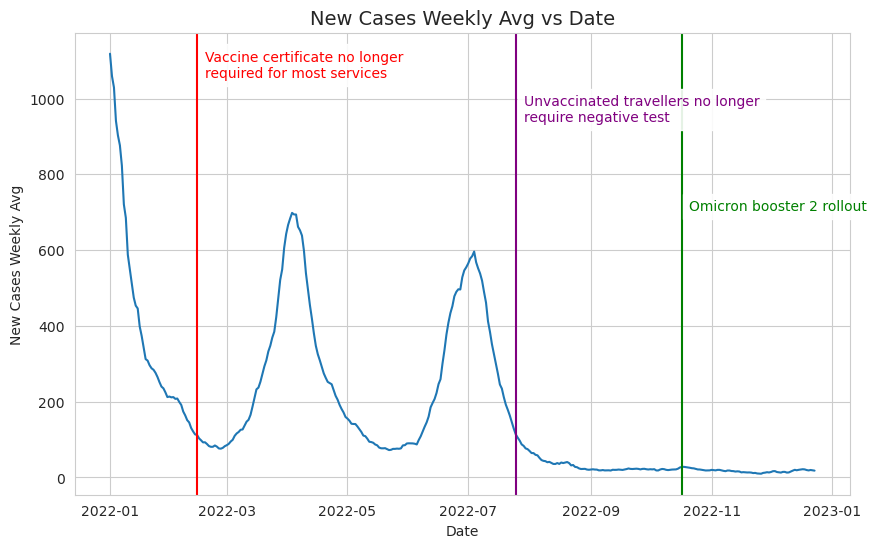

In [48]:
plot_helper('line',df_covid_agg_2022, 'date' , 'new_cases_weekly_avg')
add_plot_line('14/02/2022','Vaccine certificate no longer\nrequired for most services','red',4,0.9)
add_plot_line('25/07/2022','Unvaccinated travellers no longer\nrequire negative test','purple',4,0.8)
add_plot_line('17/10/2022','Omicron booster 2 rollout','green',3.5,0.6)

2022 saw the removal of all COVID-19 restrictions except the use of face-masks in clinical applications. The beginning of the year saw the number of active cases decrease rapidly during the administration of the first Omicron booser. As more and more restrictions were released, the number of new cases were seen to spike and drop rapidly, settling down to low number by the beginning of September. The low number of daily cases remained the same during the end of 2022.

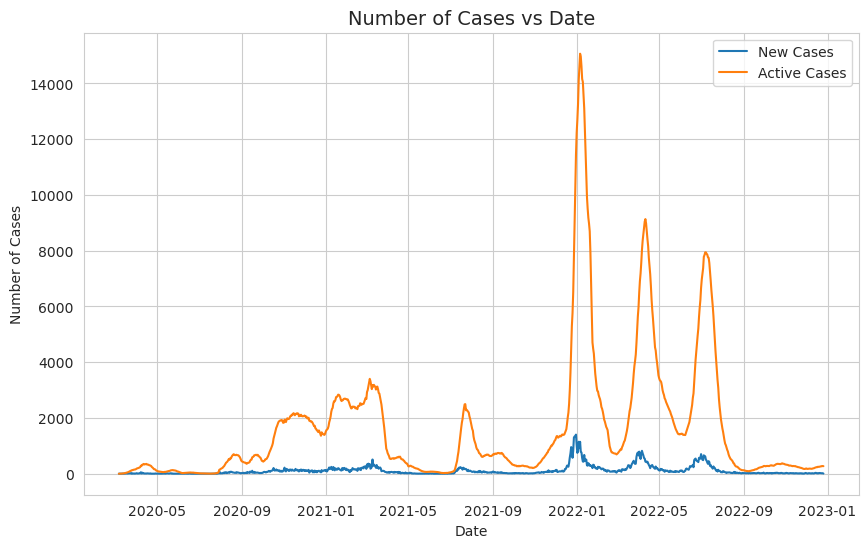

In [49]:
multi_plot_helper('line',df_covid_agg,'date',['new_cases','active_cases'],'Number of Cases')

When comparing the number of total cases and active cases, the graphs are expected to follow the same shape with different magnitudes seeing as the active cases are dependent on the number of new cases. The plot above confirms this hypothesis.

Following the daily amounts, let us look at the cumulative totals, starting with the reported deaths.

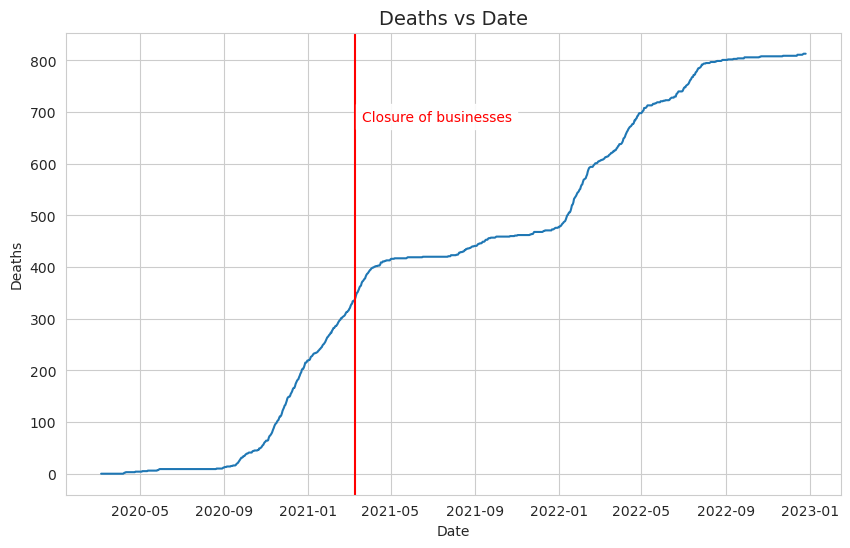

In [50]:
plot_helper('line',df_covid_agg,'date','deaths')
add_plot_line('10/03/2021','Closure of businesses','red',10,0.8)

The number of COVID-19 related deaths increased at a low but steady rate throughout most of 2020, increasing greatly towards the end of the year up til May 2021 which coincides with the business closure and vaccination rollout. The spike in cases towards the end of the year also resulted in a high mortality rate during the following months, decreasing after August 2022. The lower mortality rate can be attributed to the administration of the second Omicron booster to the vulnerable population which started during this time. 

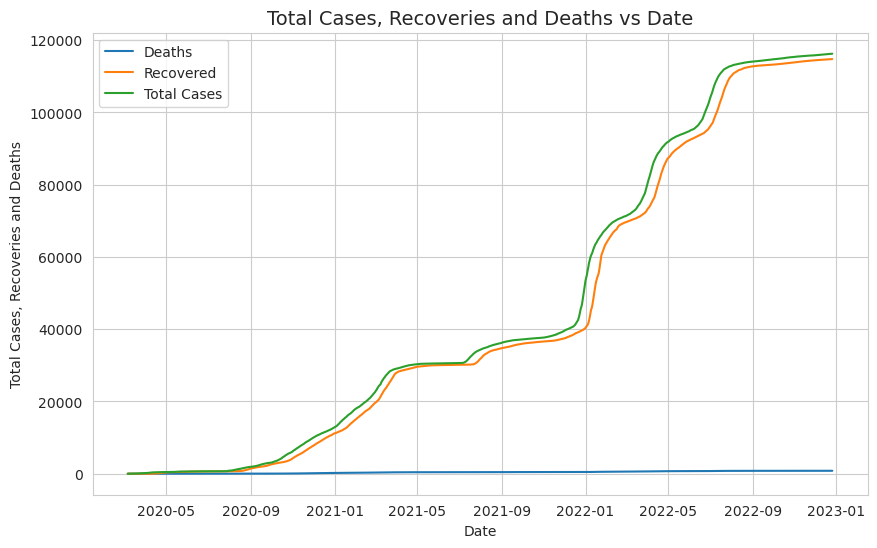

In [51]:
multi_plot_helper('line',df_covid_agg,'date',['deaths','recovered','total_cases'],'Total Cases, Recoveries and Deaths')

Given that a high percentage of all active cases resulted in a subsequent recovery, the total and recovered case totals following a similar trend with a slight shift. The shift is expected given the time to recover and/or the quarantine period. 

Let us now consider the weekly tests.

In [52]:
df_covid_tests['daily_pcr_weekly_avg'] = df_covid_tests[['daily_pcr']].rolling(7).mean().shift(-3) # a rolling average to have a smoother curve
df_covid_tests['daily_rapid_weekly_avg'] = df_covid_tests[['daily_rapid']].rolling(7).mean().shift(-3)
df_covid_tests['total_daily_tests_weekly_avg'] = df_covid_tests[['total_daily_tests']].rolling(7).mean().shift(-3) 

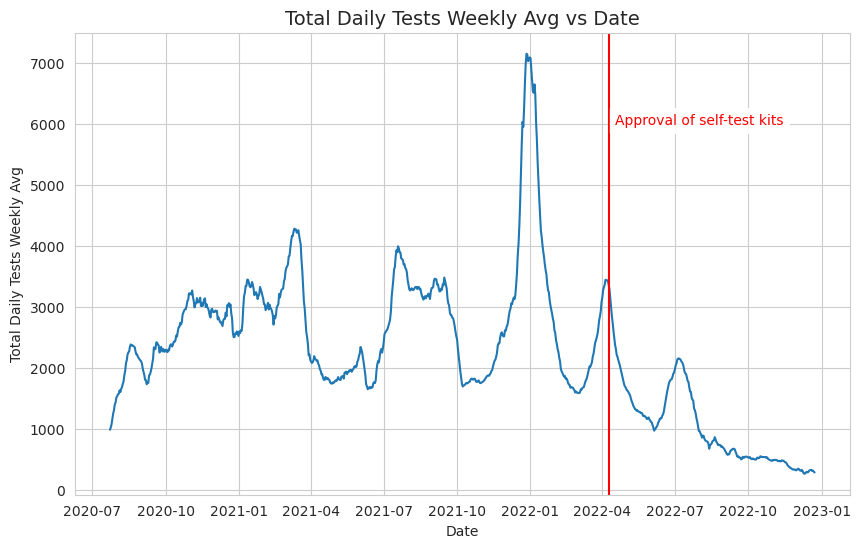

In [53]:
plot_helper('line',df_covid_tests,'date','total_daily_tests_weekly_avg')
add_plot_line('10/04/2022','Approval of self-test kits','red',7,0.8)

The total daily tests are the sum of the PCR and rapid tests carried out throughout the day, starting from July 20th 2020. The number of tests increased until March 2021 after which the number of tests were halved. This coincides with the non-essential business closure which saw less people leaving their homes on a daily basis. Another spike in tests was noted during the summer months. This may be attributed to the testing requirements for travelling. The total daily tests stayed above 2000 per day, peaking during the spike in COVID cases at the end of 2021. After the introduction of self-test kits (https://newsbook.com.mt/en/covid-five-self-testing-kits-approved-by-maltese-health-authorities/https://newsbook.com.mt/en/covid-five-self-testing-kits-approved-by-maltese-health-authorities/), the number of cases decreased greatly. The downward trend continued following a spike in July, as the number of tests approached 500 by the end of 2022.

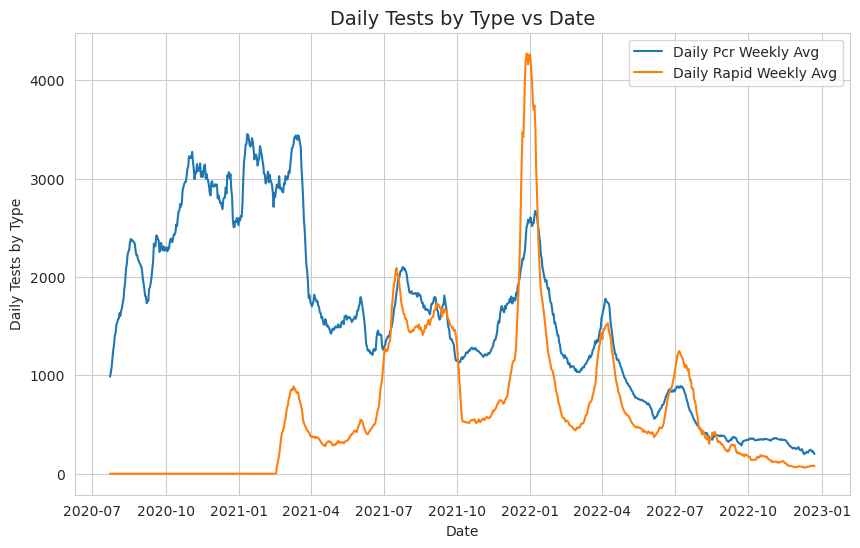

In [54]:
multi_plot_helper('line',df_covid_tests,'date',['daily_pcr_weekly_avg','daily_rapid_weekly_avg'],'Daily Tests by Type')

During the first months of the pandemic, the only official tests were the PCR tests. When rapid tests started to be officially recognised as part of the test counts, the number of rapid tests matched and eventually surpassed the number of PCR tests being performed daily by the time of the peak in late 2021. Throughout the rest of 2021, the number of PCR tests and rapid tests decreased and remained relatively similar.

Looking at the vaccination data:

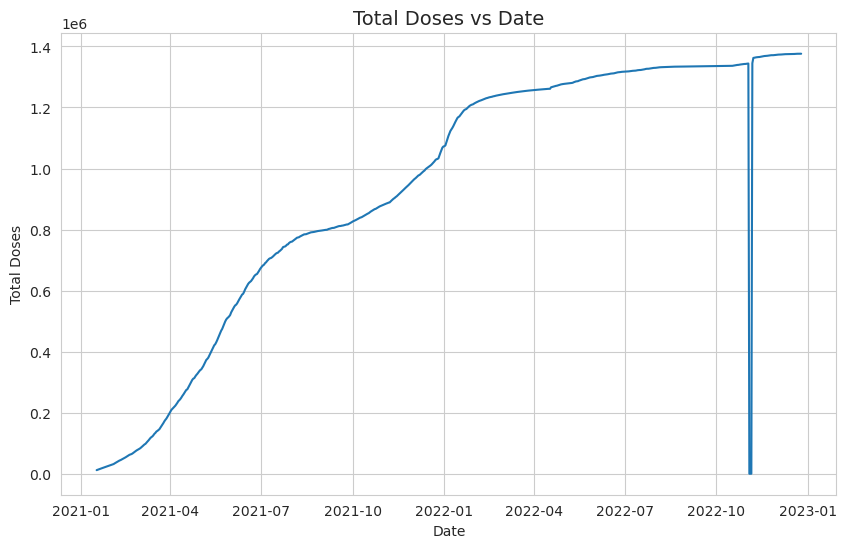

In [55]:
plot_helper('line',df_covid_vacc,'date','total_doses')

There seems to be a data issue towards the end of 2022. When we locate the data, there are a number of days with only the primary vaccinations reported.

In [56]:
df_covid_vacc.iloc[650:660]

,date,total_doses,primary_vacc,one_dose,total_booster_1,total_booster_2,daily_booster_omicron,total_booster_omicron
650,2022-10-29,1342606,471080,478265,360779,66845,0,0
651,2022-10-30,1342696,471083,478266,360780,66930,0,0
652,2022-10-31,1343194,471085,478271,360805,67396,0,0
653,2022-11-01,1343752,471090,478274,360838,67913,0,0
654,2022-11-02,1344146,471097,478280,360872,68260,0,0
655,2022-11-03,0,471098,0,0,0,0,0
656,2022-11-04,0,471115,0,0,0,0,0
657,2022-11-05,0,471098,0,0,0,0,0
658,2022-11-06,1345046,471117,478303,360925,69082,0,0
659,2022-11-07,1362417,471118,478304,360948,69475,474,16953


To remediate this issue, we will be replacing the 0 values with linear interpolation based on row indices 654 and 658. 

In [57]:
for col_idx in [1,3,4,5]:
    step_size = int((df_covid_vacc.iloc[658,col_idx] - df_covid_vacc.iloc[654,col_idx])/ 4)
    for row_idx in range(655,658):
        df_covid_vacc.iloc[row_idx,col_idx] = df_covid_vacc.iloc[row_idx-1,col_idx] + step_size
    

In [58]:
 df_covid_vacc.iloc[654:659]

,date,total_doses,primary_vacc,one_dose,total_booster_1,total_booster_2,daily_booster_omicron,total_booster_omicron
654,2022-11-02,1344146,471097,478280,360872,68260,0,0
655,2022-11-03,1344371,471098,478285,360885,68465,0,0
656,2022-11-04,1344596,471115,478290,360898,68670,0,0
657,2022-11-05,1344821,471098,478295,360911,68875,0,0
658,2022-11-06,1345046,471117,478303,360925,69082,0,0


Looking at the graph now, the issue is less apparent.

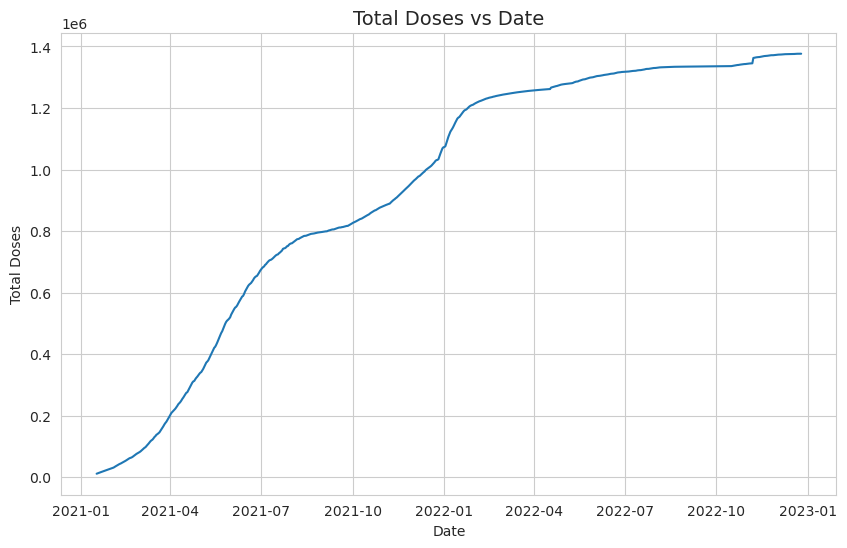

In [59]:
plot_helper('line',df_covid_vacc,'date','total_doses')

From the beginning of 2021, the number of vaccinations increased in rate as more age groups were inoculated. The numbers started to reduce as most of the population was vaccinated by the end of the summer months. As the first booster was introduced in November, the number of vaccinations increased to a similar rate as the primary vaccination. Following the first booster dose, the rate of daily vaccinations slowed down, with a slight increase noted as the second Omicron booster was rolled out.

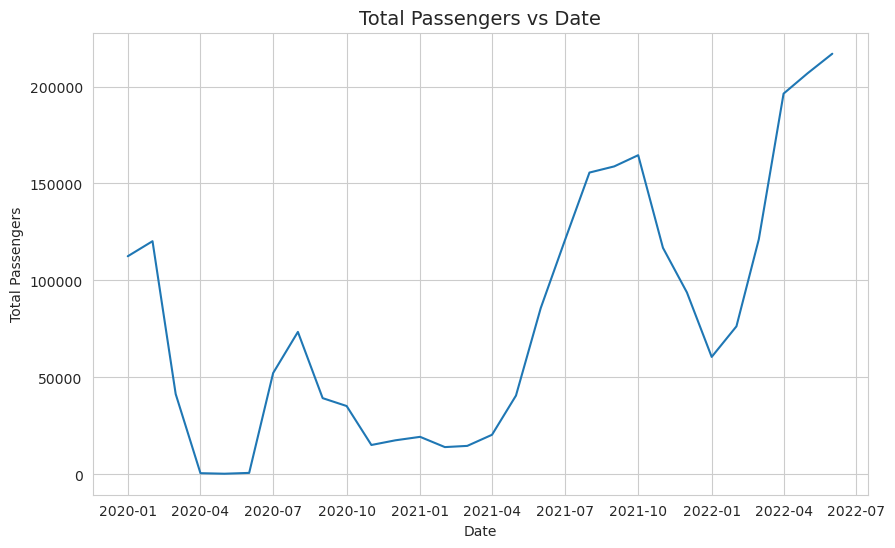

In [60]:
plot_helper('line',df_monthly_passengers,'date','total_passengers')

The number of passengers arriving through aerial channels at the MIA normally varies during the different months of the year due to various factors:
- Tourism
- Workplace shutdowns
- Holidays

COVID-19 saw a large drop in tourism and travelling in general. While the rates are recovering globally, they are still not at the pre-pandemic levels.

In Malta, the number of incoming passengers decreased close to 0 after March 2020. This is expected following the travel ban where only limited repatriation flights were allowed. As more countries were removed from the red zone, the number of passengers increased albeit to much lower levels then usual. The number of passengers increased again between April and October, dropping to less than half by the end of the year following the surge in COVID-19 cases. During 2022, the flight numbers increased exponentially, peaking at over 230,000 inbound passengers by June 2022. Compared to the pre-COVID reported numbers of approximately 270,000 inbound aerial tourists in 2019, (https://nso.gov.mt/en/News_Releases/Documents/2022/08/News2022_138.pdf), June 2022 had reached ~80% of that amount. 

### Merging Datasets

To better analyze the correlation between the available COVID-19 datasets and the flight datasets, we will be merging the datasets together in order to have the following:

- A dataset detailing the COVID-19 cases and the data related to testing
- A dataset detailing the COVID-19 cases and the data related to vaccinations
- A dataset detailing the number of monthly COVID-19 cases and the incoming flight passengers

In [61]:
# Daily Case Totals and Test Data
df_covid_agg_tests = df_covid_agg.merge(df_covid_tests, on='date')
df_covid_agg_tests.head()

,date,new_cases,total_cases,recovered,deaths,active_cases,new_cases_weekly_avg,daily_pcr,total_pcr,daily_rapid,total_rapid,total_daily_tests,total_tests,daily_pcr_weekly_avg,daily_rapid_weekly_avg,total_daily_tests_weekly_avg
0,2020-07-20,1,677,664,9,4,0.857143,583,113820,0,0,583,113820,NaN,NaN,NaN
1,2020-07-21,0,677,664,9,4,1.714286,959,114779,0,0,959,114779,NaN,NaN,NaN
2,2020-07-22,2,679,665,9,5,1.571429,1016,115795,0,0,1016,115795,NaN,NaN,NaN
3,2020-07-23,1,680,665,9,6,3.428571,1114,116909,0,0,1114,116909,986.857143,0.0,986.857143
4,2020-07-24,6,686,665,9,12,3.428571,931,117840,0,0,931,117840,1025.000000,0.0,1025.000000


In [70]:
# Daily Case Totals and Vaccination Data
df_covid_agg_vacc = df_covid_agg.merge(df_covid_vacc, on='date')
df_covid_agg_vacc.head()

,date,new_cases,total_cases,recovered,deaths,active_cases,new_cases_weekly_avg,total_doses,primary_vacc,one_dose,total_booster_1,total_booster_2,daily_booster_omicron,total_booster_omicron
0,2021-01-17,141,15588,12596,239,2753,167.285714,11705,0,0,0,0,0,0
1,2021-01-18,154,15742,12717,241,2784,171.571429,13002,0,0,0,0,0,0
2,2021-01-19,200,15942,12865,242,2835,164.428571,14276,0,0,0,0,0,0
3,2021-01-20,187,16129,13054,244,2831,156.428571,15316,0,0,0,0,0,0
4,2021-01-21,151,16280,13234,245,2801,152.857143,16531,0,0,0,0,0,0


In [63]:
# Monthly Case Totals and Incoming Airline Passengers
df_covid_agg_monthly = df_covid_agg[['date','new_cases']] # extract the dates and new cases 
df_covid_agg_monthly = df_covid_agg_monthly.groupby(pd.Grouper(key='date',freq='M')).sum() # get the sum of new cases grouped by date
df_covid_agg_monthly.reset_index(inplace=True) # add the date back as a column instead of an index
df_covid_agg_monthly['date'] = df_covid_agg_monthly['date'] + pd.offsets.Day() #- pd.offsets.MonthBegin() # change the date to be the start of the month (in line with the flight dataset)
df_covid_agg_monthly.head(10)

,date,new_cases
0,2020-04-01,169
1,2020-05-01,296
2,2020-06-01,153
3,2020-07-01,52
4,2020-08-01,154
5,2020-09-01,1164
6,2020-10-01,1175
7,2020-11-01,2984
8,2020-12-01,3831
9,2021-01-01,2901


In [64]:
df_covid_agg_flights = df_covid_agg_monthly.merge(df_monthly_passengers, on='date')
df_covid_agg_flights.head()

,date,new_cases,total_passengers
0,2020-04-01,169,629
1,2020-05-01,296,351
2,2020-06-01,153,778
3,2020-07-01,52,52268
4,2020-08-01,154,73473


### Multivariate Analysis

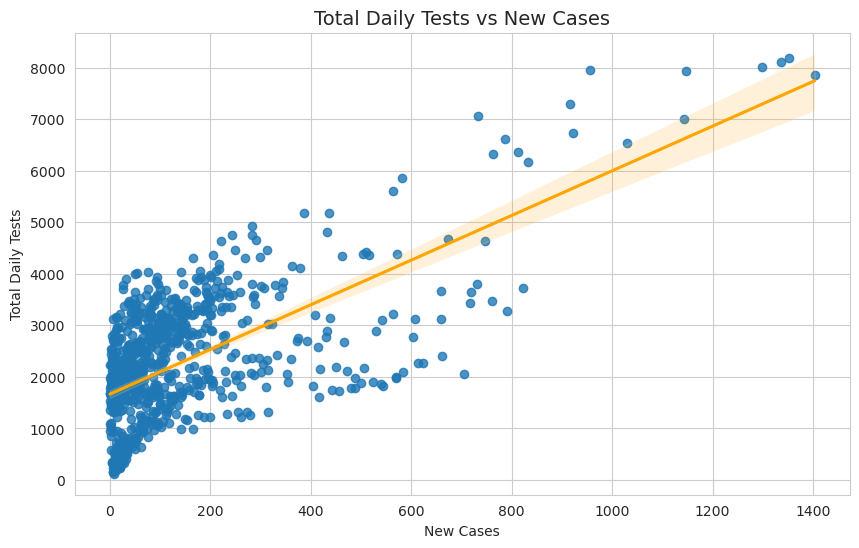

In [65]:
plot_helper('regression',df_covid_agg_tests,'new_cases','total_daily_tests')

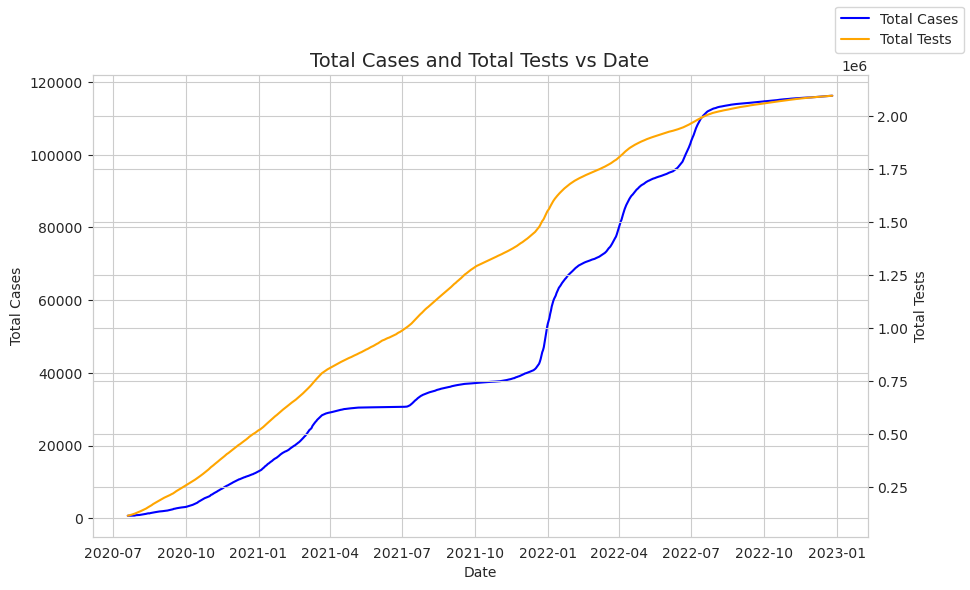

In [66]:
dual_axis_plot_helper(df_covid_agg_tests, 'date', 'total_cases','total_tests')

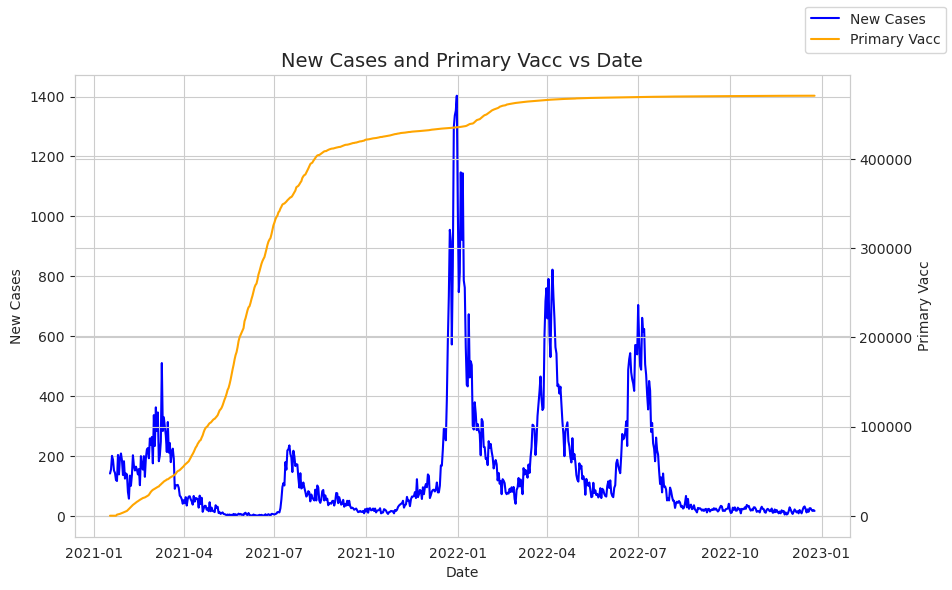

In [74]:
dual_axis_plot_helper(df_covid_agg_vacc, 'date', 'new_cases', 'primary_vacc')

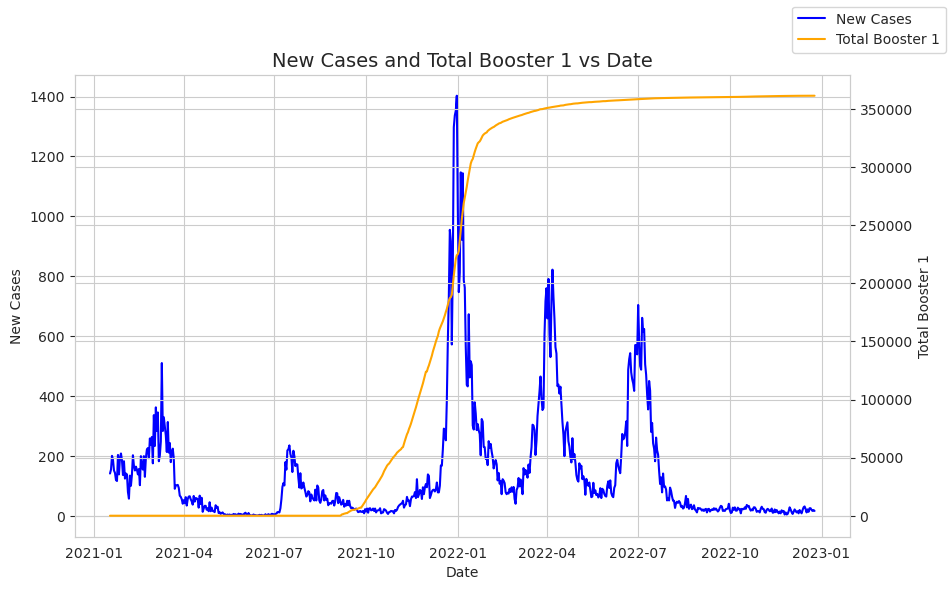

In [72]:
dual_axis_plot_helper(df_covid_agg_vacc, 'date', 'new_cases', 'total_booster_1')

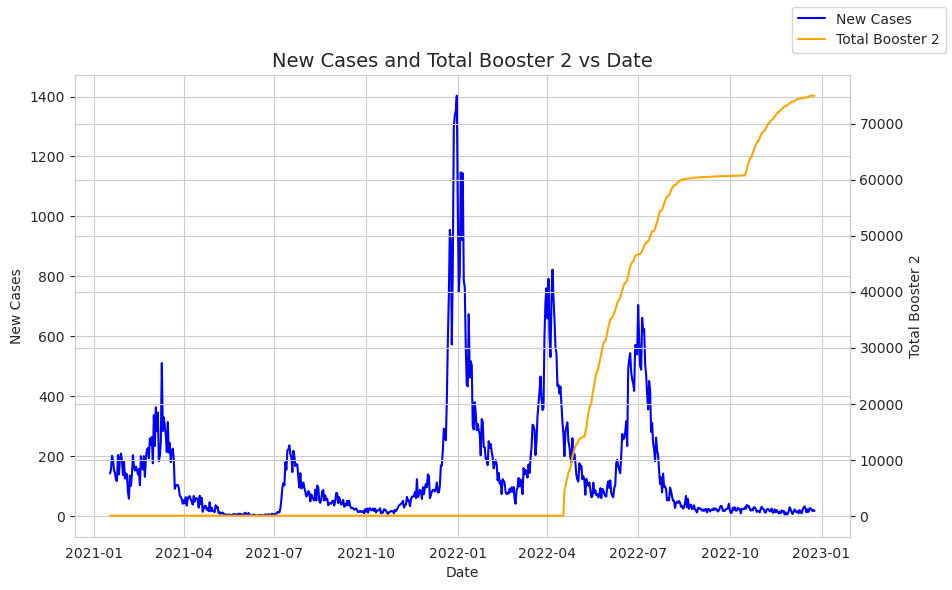

In [75]:
dual_axis_plot_helper(df_covid_agg_vacc, 'date', 'new_cases', 'total_booster_2')

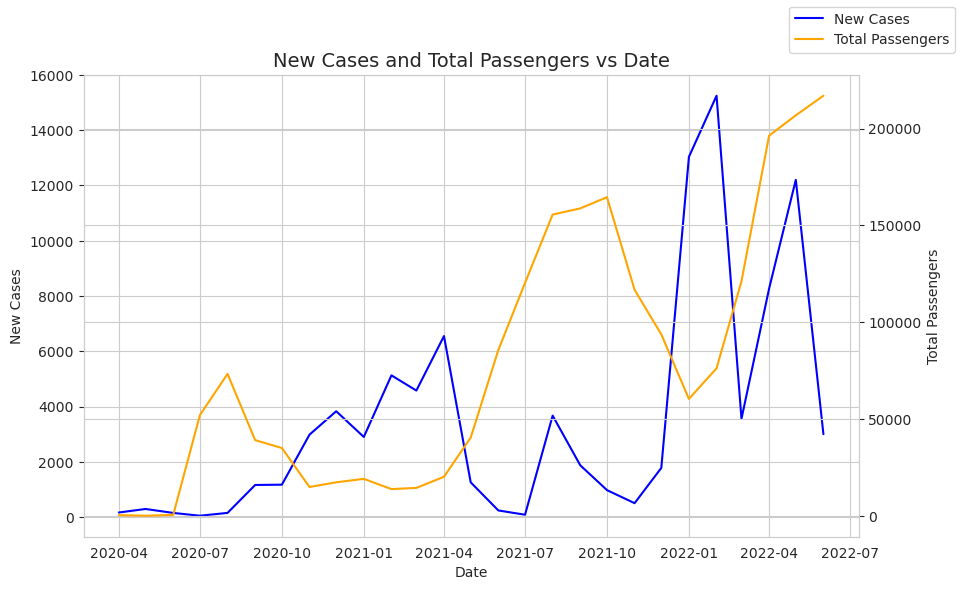

In [68]:
dual_axis_plot_helper(df_covid_agg_flights, 'date', 'new_cases', 'total_passengers')